In [1]:
from dotenv import load_dotenv, find_dotenv
from openai import AzureOpenAI
import os
import json

import base64
from mimetypes import guess_type

load_dotenv(find_dotenv())

api_base = os.getenv("GPT4V_ENDPOINT")
api_key= os.getenv("AZURE_OPENAI_API_KEY")
deployment_name = 'gpt4-vision'
api_version = '2023-12-01-preview'

client = AzureOpenAI(
    api_key=api_key,  
    api_version=api_version,
    base_url=f"{api_base}/openai/deployments/{deployment_name}/extensions",
)

# Function to encode a local image into data URL 
def local_image_to_data_url(image_path):
    # Guess the MIME type of the image based on the file extension
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        mime_type = 'application/octet-stream'  # Default MIME type if none is found

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"

In [2]:
import cv2
import numpy as np
import sys
from pdf2image import convert_from_path

def set_working_directory():
    # 當程式被 PyInstaller 打包時
    if hasattr(sys, '_MEIPASS'):
        # 設置工作目錄為可執行文件所在的目錄
        exe_dir = os.path.dirname(os.path.abspath(sys.executable))
    else:
        # 當程式在開發環境中執行時
        exe_dir = os.path.dirname(os.path.abspath(__file__))
        # 回到上一層目錄，即專案根目錄
        exe_dir = os.path.dirname(exe_dir)

    # 設置工作目錄為可執行文件所在的目錄
    os.chdir(exe_dir)

    return os.getcwd()

In [55]:
image = convert_from_path('./myown.pdf', dpi =300, poppler_path="..\\..\\poppler-24.02.0\\Library\\bin")
img = np.asarray(image[0])
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# 自動二值化
_, img_th = cv2.threshold(img_gray, 238, 255, cv2.THRESH_BINARY)
cv2.imwrite('myown.jpeg', img_th)

True



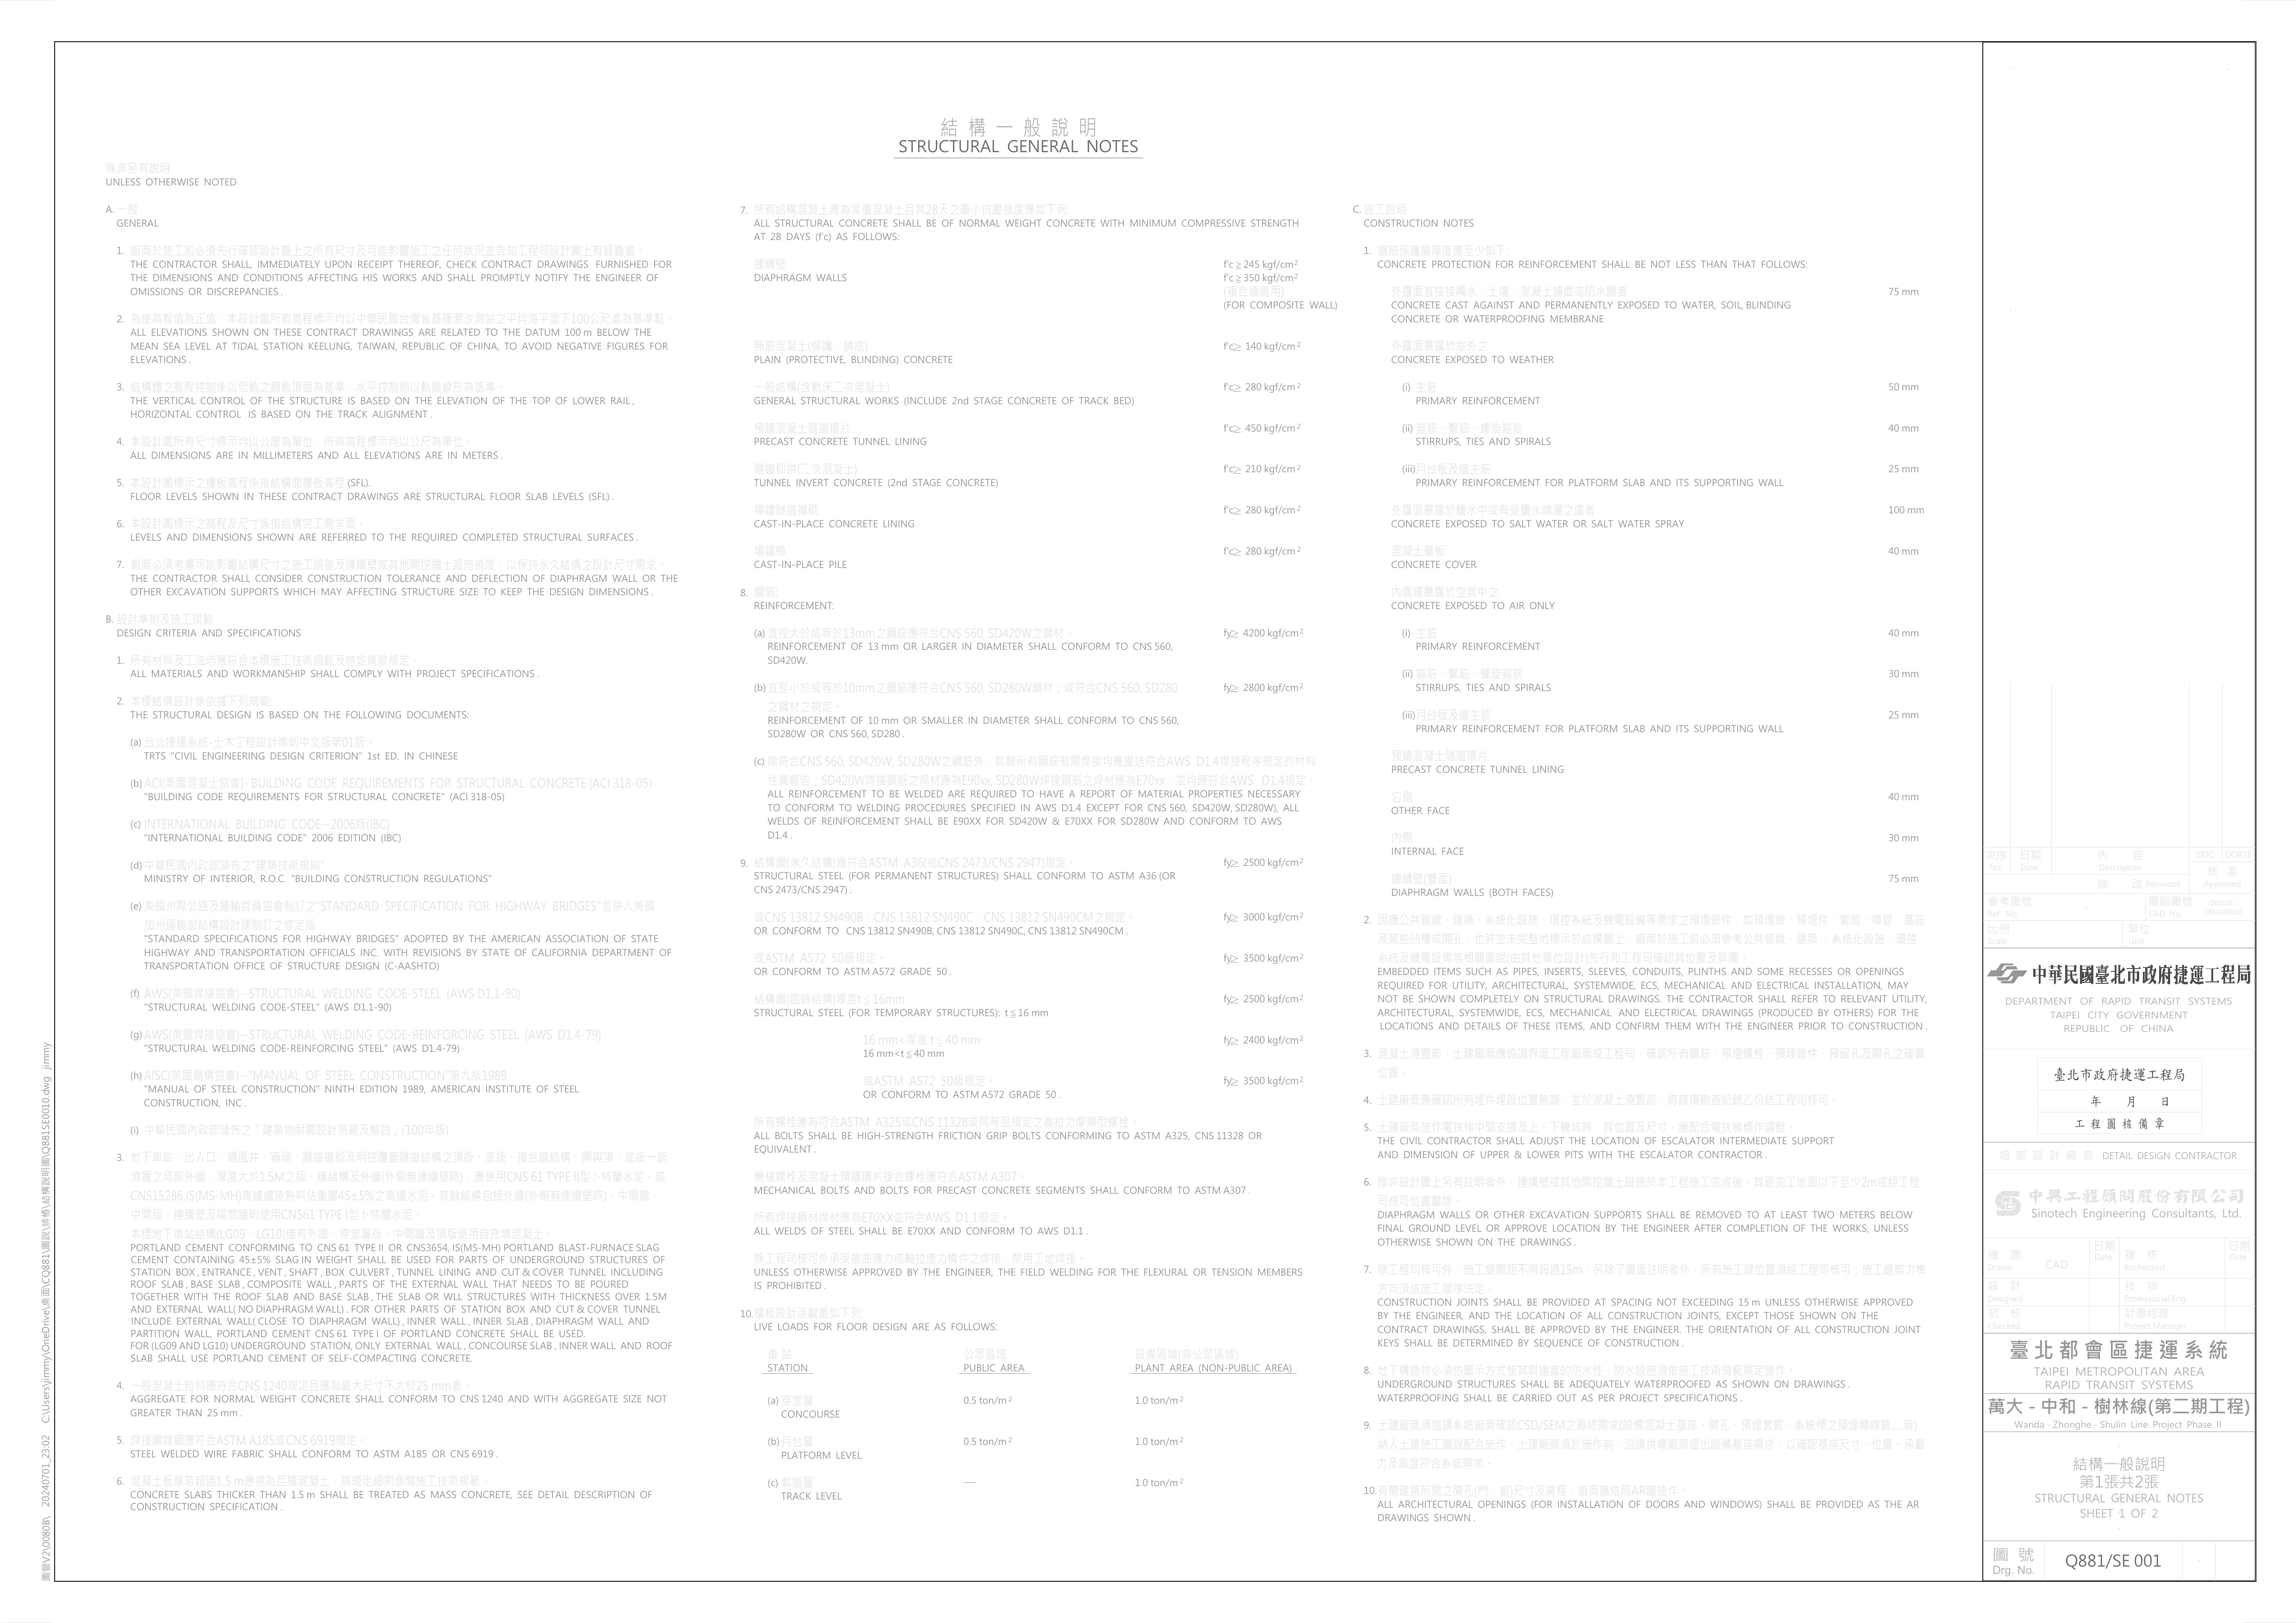

In [38]:
img_path = 'myown.jpeg'
image_data_url = local_image_to_data_url(img_path)
print(image_data_url)

In [72]:
template = """
請根據以下圖說，回答問題：
1. 在[c.施工說明]底下的[1.鋼筋保護層厚度應至少如下:]底下的外露面直接接觸水、土壤、混凝土舖面或防水膜者的鋼筋保護層厚度應該為多少mm?
2. 在[c.施工說明]底下的[1.鋼筋保護層厚度應至少如下:]底下的連續壁(雙面)的鋼筋保護層厚度應該為多少mm?
3. 在[B.設計準則及施工規範]之中的[7. 所有結構混凝土應為常重混凝土且其28天之最小抗壓強度應如下列:]底下的連續壁(複合牆適用)的f'c應該要大於多少kgf/cm^2(有兩個)?
4. 在[B.設計準則及施工規範]之中的[8. 鋼筋:]底下的直徑大於或等於13mm之鋼筋應符合CNS 560, SD420W之鋼材，請問fy應該大於多少kgf/cm^2?
5. 在[B.設計準則及施工規範]之中的[8. 鋼筋:]底下的直徑小於或等於10mm之鋼筋應符合CNS 560, SD280W鋼材，請問fy應該大於多少kgf/cm^2?
請回答數字，並以逗號分隔。不要有其他內容。
"""

template = "3. 在[B.設計準則及施工規範]之中的[7. 所有結構混凝土應為常重混凝土且其28天之最小抗壓強度應如下列:]底下的連續壁(複合牆適用)的f'c應該要大於哪兩個kgf/cm^2? 提示:內容應該與關鍵字[連續壁]平行˙"
data_url = local_image_to_data_url('myown.jpeg')

messages = [
    {
        "role": "user", 
        "content": [
            {"type": "text", "text": template},
            { 
                "type": "image_url",
                "image_url":{
                    "url": data_url,
                    "detail":"high"
                },
            },
        ],
    },
]

response = client.chat.completions.create(
    model=deployment_name,
    messages=messages,
    max_tokens=200
)
print(response)

ChatCompletion(id='chatcmpl-9hsfz2Ktx3KYSKnMgFXDAnyWCnw9g', choices=[Choice(finish_reason='length', index=0, logprobs=None, message=ChatCompletionMessage(content="在本圖所提供的[B.設計準則及施工規範]文件中，位置位於中段左側的[7. 所有結構混凝土應為常重混凝土且其28天之最小抗壓強度應如下列:]項目中，連續壁(複合牆適用)的f'c應該要大於的兩個kgf/cm^2數值分別是:\n\n1. f'c = 280公斤/平方釐米(kgf/cm^2)\n2. f'c = 350公斤/平方釐米(kgf/cm^2)\n\n這意味著連續", role='assistant', function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}})], created=1720245307, model='gpt-4', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=199, prompt_tokens=1262, total_tokens=1461), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filte

In [73]:
print(response.choices[0].message.content)

在本圖所提供的[B.設計準則及施工規範]文件中，位置位於中段左側的[7. 所有結構混凝土應為常重混凝土且其28天之最小抗壓強度應如下列:]項目中，連續壁(複合牆適用)的f'c應該要大於的兩個kgf/cm^2數值分別是:

1. f'c = 280公斤/平方釐米(kgf/cm^2)
2. f'c = 350公斤/平方釐米(kgf/cm^2)

這意味著連續
